# CMO E010018A
钱德动量摆动指标（Chande Momentum Osciliator）

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '15Min',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

8.419058322906494


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()

In [4]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:
import matplotlib.pyplot as plt
def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [6]:
dv.add_formula('SU', "Ts_Sum(If(Delta(close,1)>0,close-Delay(close, 1),0),20)" ,add_data=True)
dv.add_formula('SD', "Ts_Sum(If(Delta(close,1)<0,Delay(close, 1)-close,0),20)",add_data=True)
CMO_J = dv.add_formula('CMO_J', "(SU-SD)/(SU+SD)*100",add_data=True)

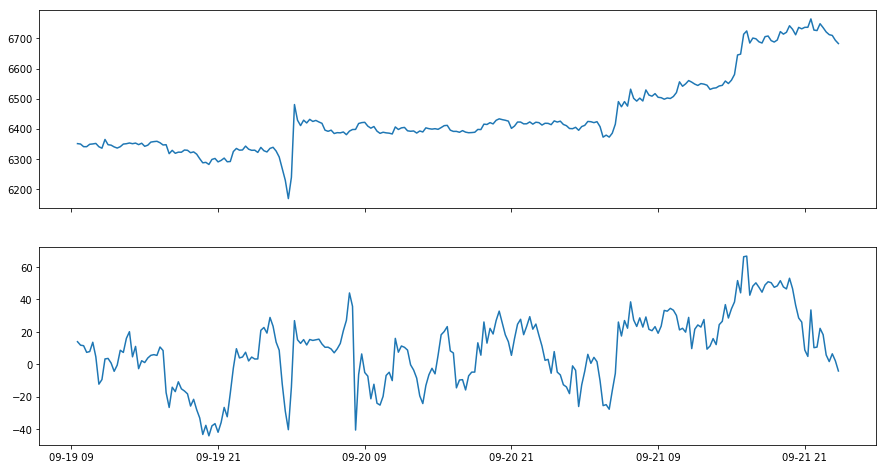

In [7]:
CMO_plot = dv.get_ts('CMO_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

plot_chart(close, CMO_plot)

CMO指标与收盘价基本呈正相关，其绝对值越高，表现出的趋势越强，绝对值在20以内的，股价基本上呈水平移动。
进出场假设：当CMO上穿0线，买入信号产生；当CMO下穿0线，卖出信号产生。

# Fiftytwoweekhigh

In [22]:
import pandas as pd
def CalPos(price, n):
    result = []
    for col in price.columns:
        data = price[col].dropna()
        data = (data - data.rolling(n).min()) / (data.rolling(n).max() - data.rolling(n).min())
        result.append(data)
    return pd.concat(result, axis=1)
Fiftytwoweekhigh = dv.add_formula("Fiftytwoweekhigh","CalPos(close,252)" ,add_data=True,register_funcs={"CalPos": CalPos})

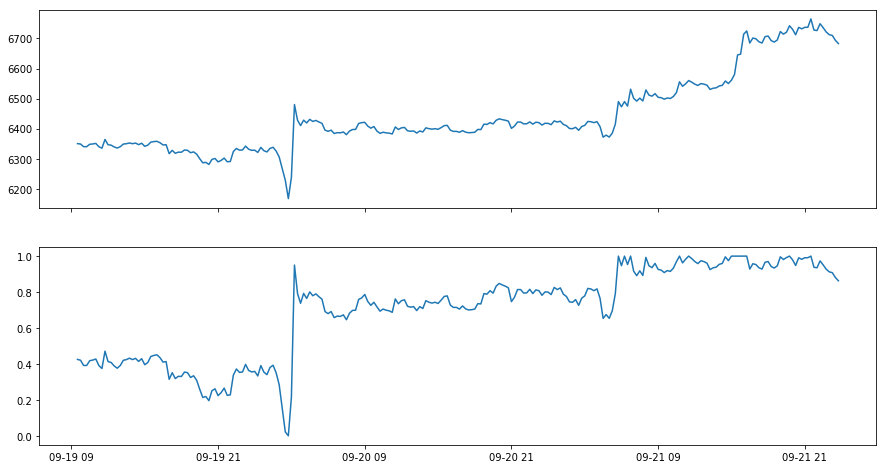

In [23]:
Fiftytwoweekhigh_plot = dv.get_ts('Fiftytwoweekhigh', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

plot_chart(close, Fiftytwoweekhigh_plot)

# 进出场假设：当CMO上穿0线，买入信号产生；当CMO下穿0线，卖出信号产生。

走势基本相同，越接近1趋势越明显。

In [8]:
# 进场信号
long = dv.add_formula('long','If(CMO_J>0, 2, 0)', add_data=True)
short = dv.add_formula('short','If(CMO_J<0, -2, 0)', add_data=True)
# 出场信号
close_long = dv.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [9]:
dv.get_ts('long').stack()[dv.get_ts('long').stack()==2]#观察出现做多信号的时间点

trade_date      symbol         
20180101050000  BTCUSDT:binance    2.0
20180101051500  BTCUSDT:binance    2.0
20180101054500  BTCUSDT:binance    2.0
20180101060000  BTCUSDT:binance    2.0
20180101061500  BTCUSDT:binance    2.0
20180101064500  BTCUSDT:binance    2.0
20180101130000  BTCUSDT:binance    2.0
20180101131500  BTCUSDT:binance    2.0
20180101133000  BTCUSDT:binance    2.0
20180101134500  BTCUSDT:binance    2.0
20180101140000  BTCUSDT:binance    2.0
20180101141500  BTCUSDT:binance    2.0
20180101143000  BTCUSDT:binance    2.0
20180101144500  BTCUSDT:binance    2.0
20180101150000  BTCUSDT:binance    2.0
20180101151500  BTCUSDT:binance    2.0
20180101153000  BTCUSDT:binance    2.0
20180101154500  BTCUSDT:binance    2.0
20180101160000  BTCUSDT:binance    2.0
20180101161500  BTCUSDT:binance    2.0
20180101164500  BTCUSDT:binance    2.0
20180101170000  BTCUSDT:binance    2.0
20180101171500  BTCUSDT:binance    2.0
20180101173000  BTCUSDT:binance    2.0
20180101174500  BTCUSDT:binance 

In [10]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger
tdCMO = TimingDigger(output_folder=".", output_format='pdf',signal_name='CMO')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称
    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [11]:
TimingSignal(tdCMO, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 50%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 48%


In [12]:
tdCMO.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                         win      loss        all
t-stat                36.043   -86.311    -16.027
p-value                0.000     0.000      0.000
mean                   0.011    -0.008     -0.002
std                    0.019     0.009      0.016
info_ratio             0.567    -0.923     -0.142
skewness               4.189    -2.204      3.106
kurtosis              25.371     6.512     27.340
pct5                   0.000    -0.026     -0.023
pct25                  0.001    -0.011     -0.007
pct50                  0.004    -0.005     -0.002
pct75                  0.011    -0.002      0.001
pct95                  0.045    -0.000      0.018
occurance           4037.000  8741.000  12778.000
win_ratio                NaN       NaN      0.316
win_mean/loss_mean       NaN       NaN      1.309


In [13]:
tdCMO.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                         win      loss        all
t-stat                45.025   -73.248    -13.688
p-value                0.000     0.000      0.000
mean                   0.012    -0.009     -0.002
std                    0.017     0.011      0.016
info_ratio             0.724    -0.809     -0.125
skewness               2.473    -2.819      1.007
kurtosis               7.885    10.283      8.755
pct5                   0.000    -0.031     -0.025
pct25                  0.002    -0.011     -0.007
pct50                  0.005    -0.005     -0.002
pct75                  0.016    -0.002      0.001
pct95                  0.047    -0.000      0.026
occurance           3869.000  8194.000  12063.000
win_ratio                NaN       NaN      0.321
win_mean/loss_mean       NaN       NaN      1.394


In [14]:
tdCMO.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                         win       loss        all
t-stat                56.722   -111.621    -20.998
p-value                0.000      0.000      0.000
mean                   0.011     -0.008     -0.002
std                    0.018      0.010      0.016
info_ratio             0.638     -0.858     -0.133
skewness               3.487     -2.644      2.018
kurtosis              18.730      9.641     17.502
pct5                   0.000     -0.028     -0.024
pct25                  0.001     -0.011     -0.007
pct50                  0.004     -0.005     -0.002
pct75                  0.013     -0.002      0.001
pct95                  0.046     -0.000      0.022
occurance           7906.000  16935.000  24841.000
win_ratio                NaN        NaN      0.318
win_mean/loss_mean       NaN        NaN      1.352


In [4]:
#测试因子通用性
start = time()
path2 = r'./min_data/VnTrader_1Min_Db'
props2 = {'fields': 'open,high,low,close,volume','symbol': \
         'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path2,props2) #读取数据
print(time()-start)

6.435085296630859


In [5]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [7]:
import matplotlib.pyplot as plt
def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [8]:
dv.add_formula('SU', "Ts_Sum(If(Delta(close,1)>0,close-Delay(close, 1),0),20)" ,add_data=True)
dv.add_formula('SD', "Ts_Sum(If(Delta(close,1)<0,Delay(close, 1)-close,0),20)",add_data=True)
CMO_J = dv.add_formula('CMO_J', "(SU-SD)/(SU+SD)*100",add_data=True)

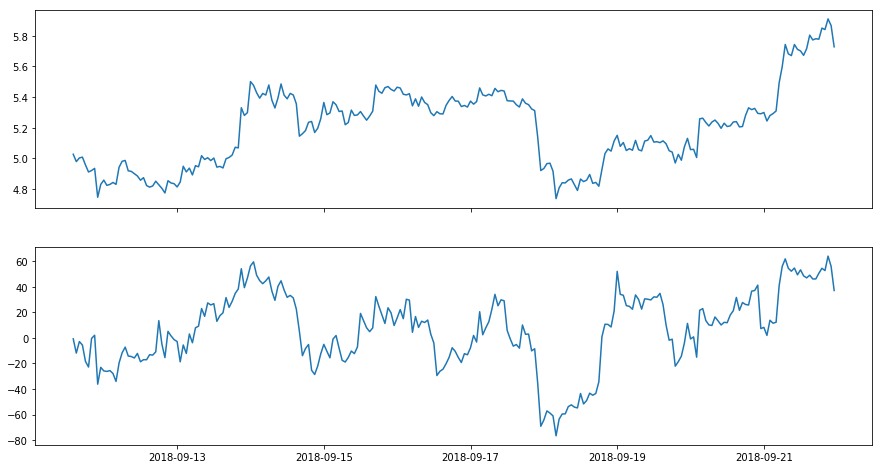

In [9]:
CMO_plot = dv.get_ts('CMO_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

plot_chart(close, CMO_plot)

In [10]:
# 进场信号
long = dv.add_formula('long','If(CMO_J>0, 2, 0)', add_data=True)
short = dv.add_formula('short','If(CMO_J<0, -2, 0)', add_data=True)
# 出场信号
close_long = dv.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [11]:
dv.get_ts('long').stack()[dv.get_ts('long').stack()==2]#观察出现做多信号的时间点

trade_date      symbol         
20180530010000  EOSUSDT:binance    2.0
20180530020000  EOSUSDT:binance    2.0
20180530030000  EOSUSDT:binance    2.0
20180530040000  EOSUSDT:binance    2.0
20180530050000  EOSUSDT:binance    2.0
20180530060000  EOSUSDT:binance    2.0
20180530070000  EOSUSDT:binance    2.0
20180530080000  EOSUSDT:binance    2.0
20180530090000  EOSUSDT:binance    2.0
20180530100000  EOSUSDT:binance    2.0
20180530110000  EOSUSDT:binance    2.0
20180530120000  EOSUSDT:binance    2.0
20180530130000  EOSUSDT:binance    2.0
20180530140000  EOSUSDT:binance    2.0
20180530150000  EOSUSDT:binance    2.0
20180530160000  EOSUSDT:binance    2.0
20180530170000  EOSUSDT:binance    2.0
20180530180000  EOSUSDT:binance    2.0
20180530190000  EOSUSDT:binance    2.0
20180530200000  EOSUSDT:binance    2.0
20180530210000  EOSUSDT:binance    2.0
20180531120000  EOSUSDT:binance    2.0
20180531130000  EOSUSDT:binance    2.0
20180531140000  EOSUSDT:binance    2.0
20180531160000  EOSUSDT:binance 

In [12]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger
tdCMO = TimingDigger(output_folder=".", output_format='pdf',signal_name='CMO')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称
    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [13]:
TimingSignal(tdCMO, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 43%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 52%


In [14]:
tdCMO.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               16.634  -34.707    -0.397
p-value               0.000    0.000     0.691
mean                  0.041   -0.023    -0.001
std                   0.050    0.019     0.045
info_ratio            0.806   -1.247    -0.011
skewness              1.622   -0.813     1.972
kurtosis              1.820   -0.297     5.216
pct5                  0.001   -0.060    -0.055
pct25                 0.006   -0.034    -0.024
pct50                 0.017   -0.018    -0.007
pct75                 0.053   -0.008     0.008
pct95                 0.157   -0.001     0.103
occurance           427.000  776.000  1203.000
win_ratio               NaN      NaN     0.355
win_mean/loss_mean      NaN      NaN     1.754


In [15]:
tdCMO.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               19.424  -33.366     3.371
p-value               0.000    0.000     0.001
mean                  0.047   -0.023     0.005
std                   0.058    0.021     0.053
info_ratio            0.811   -1.131     0.089
skewness              1.675   -1.211     1.979
kurtosis              1.932    0.846     5.130
pct5                  0.001   -0.066    -0.061
pct25                 0.007   -0.032    -0.021
pct50                 0.024   -0.016    -0.006
pct75                 0.056   -0.008     0.012
pct95                 0.183   -0.002     0.128
occurance           574.000  872.000  1446.000
win_ratio               NaN      NaN     0.397
win_mean/loss_mean      NaN      NaN     2.026


In [16]:
tdCMO.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                         win      loss       all
t-stat                25.479   -47.906     2.411
p-value                0.000     0.000     0.016
mean                   0.044    -0.023     0.002
std                    0.055     0.020     0.050
info_ratio             0.806    -1.180     0.047
skewness               1.687    -1.062     2.010
kurtosis               2.072     0.475     5.410
pct5                   0.001    -0.063    -0.057
pct25                  0.007    -0.033    -0.022
pct50                  0.019    -0.017    -0.006
pct75                  0.056    -0.008     0.010
pct95                  0.173    -0.001     0.110
occurance           1001.000  1648.000  2649.000
win_ratio                NaN       NaN     0.378
win_mean/loss_mean       NaN       NaN     1.911
